# Classificador de Números Escritos à Mão

Um pequeno exercício para classificar números escritos à mão usando machine learning e o dataset MNIST.






Neste exemplo, vamos usar o dataset MNIST para fazer um modelo de ML simples que consiga classificar as imagens de dígitos com seu rótulo correto (0 a 9).

In [1]:
# Baixando dataset

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784')

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [2]:
data = mnist["data"].to_numpy()
labels = mnist["target"].to_numpy()

O dataset possui 70 mil instâncias com 784 características no total (28 x 28 pixel).

In [3]:
data.shape

(70000, 784)

Dando uma olhadinha em uma das fotos, vemos:

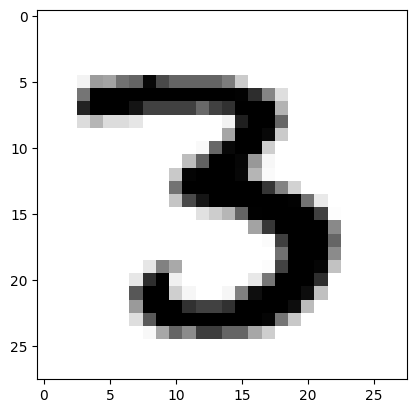

In [4]:
from matplotlib.pylab import plt

plt.imshow(data[12].reshape((28, 28)), cmap="binary")
plt.show()

## Preparando os dados

Vamos preparar os dados para realizar os experimentos.

In [5]:
from sklearn.model_selection import train_test_split
import numpy as np

labels = labels.astype(np.uint8) #convertendo os rótulos para inteiro
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.10, random_state=42, shuffle=True)

In [6]:
print("Train set size: {}".format(train_data.shape[0]))
print("Test set size: {}".format(test_data.shape[0]))

Train set size: 63000
Test set size: 7000


## Escolhendo Algoritmo

Vamos testar alguns modelos para escolher o que melhor se adequar ao nosso problema de classificação.

In [23]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def plotConfusionMatrix(y_true, y_pred, class_names):
    matrix = confusion_matrix(y_pred=y_pred, y_true=y_true)
    confusion_matrix_df = pd.DataFrame(matrix, index=class_names, columns=class_names)
    plt.figure(figsize=(15, 10))
    sn.set(font_scale=2.0)
    sn.heatmap(confusion_matrix_df, annot=True, cmap='Blues', fmt='g')

def validate_classifier(classifier, data, labels, cv=3):
    predicted_labels = cross_val_predict(classifier, data, labels, cv=cv)
    print(classification_report(y_true=labels, y_pred=predicted_labels))
    plotConfusionMatrix(labels, predicted_labels, np.unique(labels))
    return predicted_labels

Testando árvore de decisão:

              precision    recall  f1-score   support

           0       0.93      0.92      0.92      6220
           1       0.94      0.96      0.95      7077
           2       0.85      0.84      0.84      6316
           3       0.82      0.83      0.83      6381
           4       0.85      0.86      0.86      6213
           5       0.81      0.81      0.81      5655
           6       0.89      0.89      0.89      6199
           7       0.89      0.90      0.89      6569
           8       0.81      0.79      0.80      6132
           9       0.83      0.83      0.83      6238

    accuracy                           0.86     63000
   macro avg       0.86      0.86      0.86     63000
weighted avg       0.86      0.86      0.86     63000



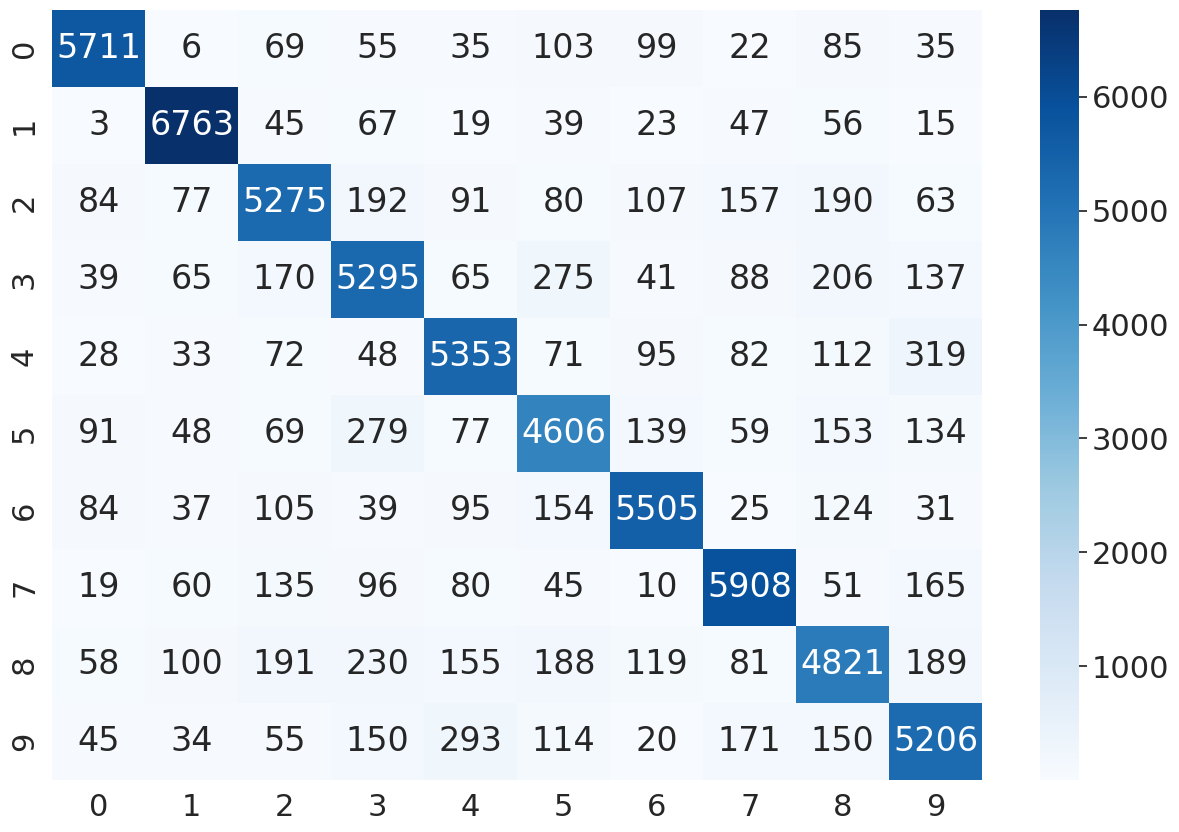

In [8]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier()

validate_classifier(decision_tree, train_data, train_labels, cv=3)

Testando floresta aleatória:

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      6220
           1       0.97      0.98      0.98      7077
           2       0.93      0.95      0.94      6316
           3       0.91      0.92      0.92      6381
           4       0.94      0.95      0.94      6213
           5       0.93      0.91      0.92      5655
           6       0.97      0.96      0.96      6199
           7       0.96      0.95      0.95      6569
           8       0.93      0.90      0.92      6132
           9       0.93      0.91      0.92      6238

    accuracy                           0.94     63000
   macro avg       0.94      0.94      0.94     63000
weighted avg       0.94      0.94      0.94     63000



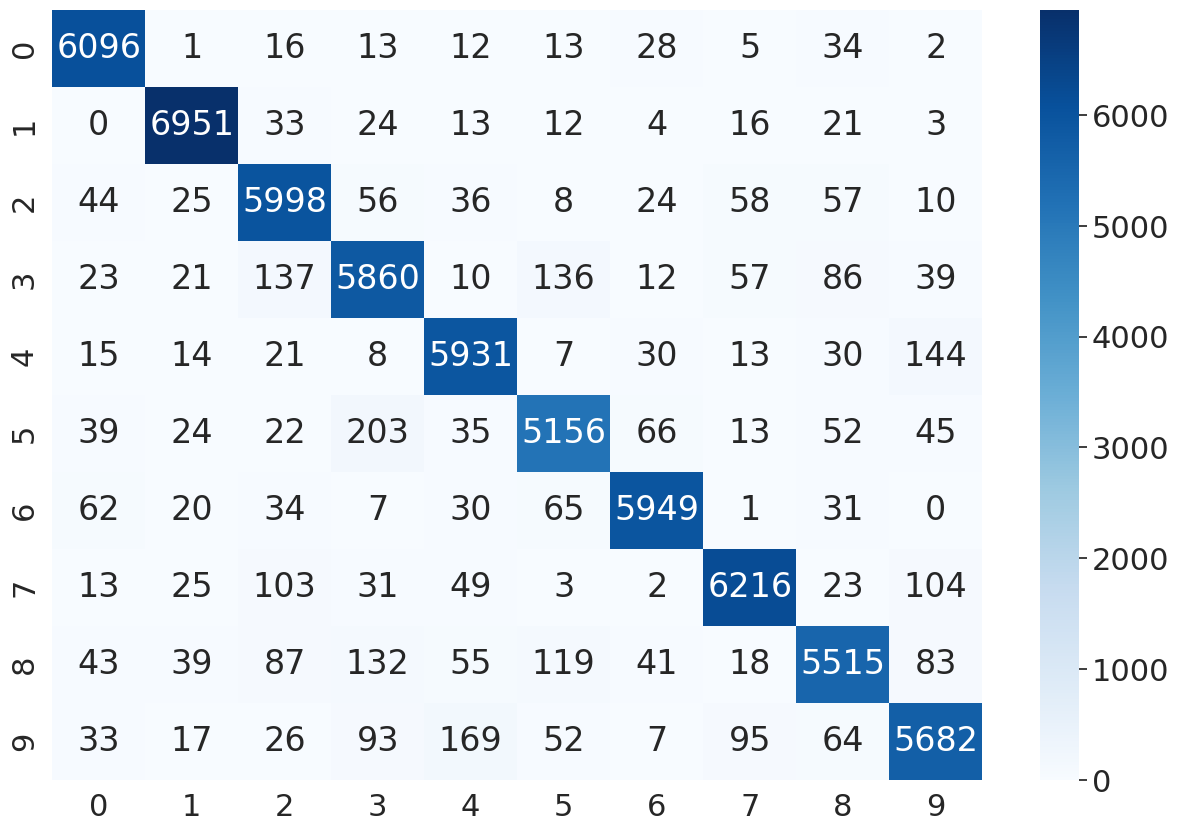

In [9]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=10)

validate_classifier(random_forest, train_data, train_labels, cv=3)

Testando K-Nearest Neighbors (KNN):

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      6220
           1       0.96      1.00      0.98      7077
           2       0.98      0.96      0.97      6316
           3       0.96      0.96      0.96      6381
           4       0.98      0.97      0.97      6213
           5       0.96      0.96      0.96      5655
           6       0.98      0.99      0.98      6199
           7       0.96      0.97      0.97      6569
           8       0.99      0.93      0.96      6132
           9       0.95      0.96      0.96      6238

    accuracy                           0.97     63000
   macro avg       0.97      0.97      0.97     63000
weighted avg       0.97      0.97      0.97     63000



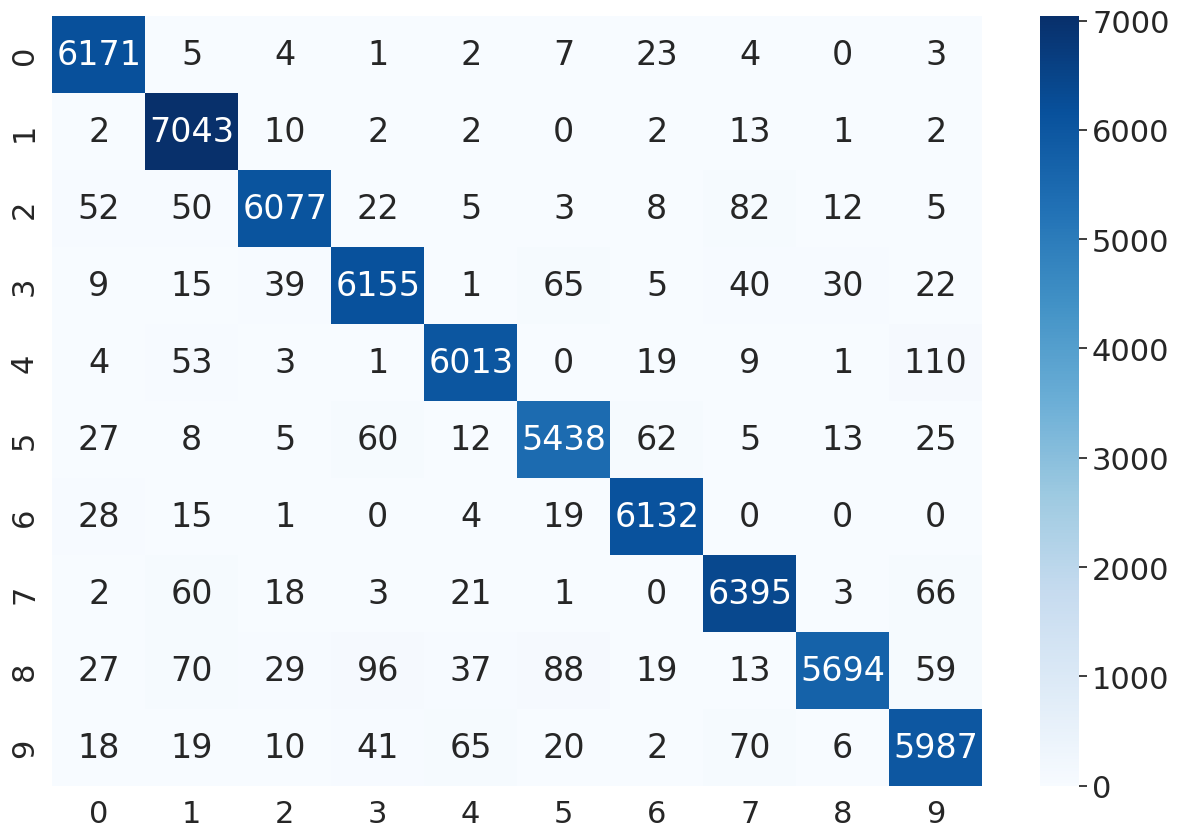

In [10]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)

validate_classifier(knn, train_data, train_labels, cv=3)

Note como, de modo geral, o KNN parece ser o algoritmo com os melhores resultado. Portanto, vamos utilizá-lo como base para resolver o problema de classificação de números escritos à mão.

## Treinando K-Nearest Neighbors (KNN)

Agora, vamos treinar um modelo de classificação baseado no KNN. Começaremos procurando por parâmetros (número de vizinhos, pesos e métrica) que melhor se adequem ao nosso algoritmo usando GridSearch (com F1 Score como métrica):

In [11]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        "n_neighbors": [3, 5, 7],
        "weights": ["uniform", "distance"],
    }
]

knn = KNeighborsClassifier()

grid_search = GridSearchCV(
    knn, param_grid, scoring="f1_macro", return_train_score=True
)
grid_search.fit(train_data, train_labels)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 5, 7],
                          'weights': ['uniform', 'distance']}],
             return_train_score=True, scoring='f1_macro')

In [25]:
best_knn = grid_search.best_estimator_
best_score = grid_search.best_score_
best_params = grid_search.best_params_

Os melhores parâmetros foram:

In [17]:
print("Melhores parâmetros: ", best_params)

Melhores parâmetros:  {'n_neighbors': 3, 'weights': 'distance'}


Analisando o desempenho do modelo:

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      6220
           1       0.96      0.99      0.98      7077
           2       0.99      0.96      0.97      6316
           3       0.97      0.96      0.97      6381
           4       0.98      0.97      0.97      6213
           5       0.96      0.96      0.96      5655
           6       0.98      0.99      0.98      6199
           7       0.96      0.97      0.97      6569
           8       0.99      0.94      0.96      6132
           9       0.95      0.96      0.96      6238

    accuracy                           0.97     63000
   macro avg       0.97      0.97      0.97     63000
weighted avg       0.97      0.97      0.97     63000



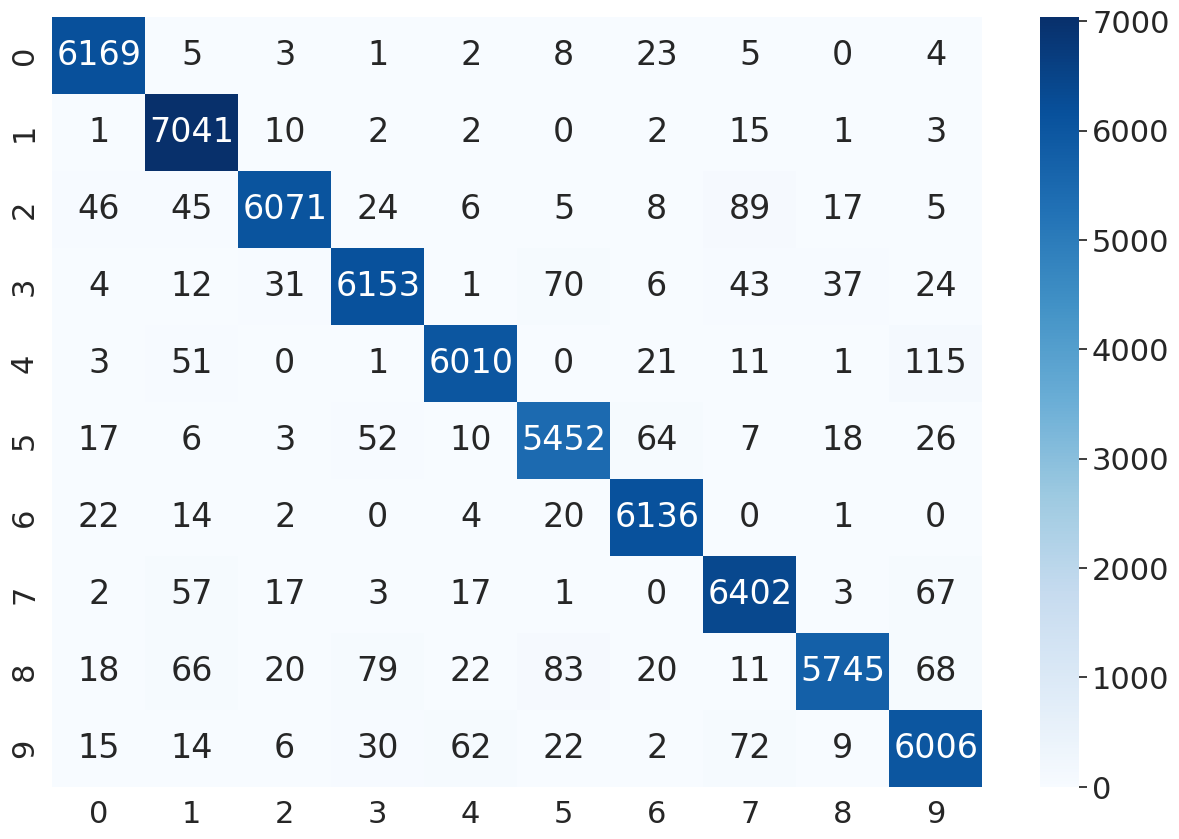

In [26]:
train_pred_labels = validate_classifier(best_knn, train_data, train_labels, cv=3)

Agora, vamos treinar o modelo escolhido com o grid search:

In [27]:
best_knn.fit(train_data, train_labels)

KNeighborsClassifier(n_neighbors=3, weights='distance')

## Testando modelo

Finalmente, vamos testar de fato a eficiência do nosso modelo.

In [28]:
test_predicted_labels = best_knn.predict(test_data)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       683
           1       0.95      0.99      0.97       800
           2       0.98      0.97      0.97       674
           3       0.97      0.97      0.97       760
           4       0.98      0.97      0.97       611
           5       0.98      0.98      0.98       658
           6       0.98      0.99      0.99       677
           7       0.96      0.97      0.96       724
           8       0.99      0.95      0.97       693
           9       0.97      0.96      0.96       720

    accuracy                           0.97      7000
   macro avg       0.97      0.97      0.97      7000
weighted avg       0.97      0.97      0.97      7000



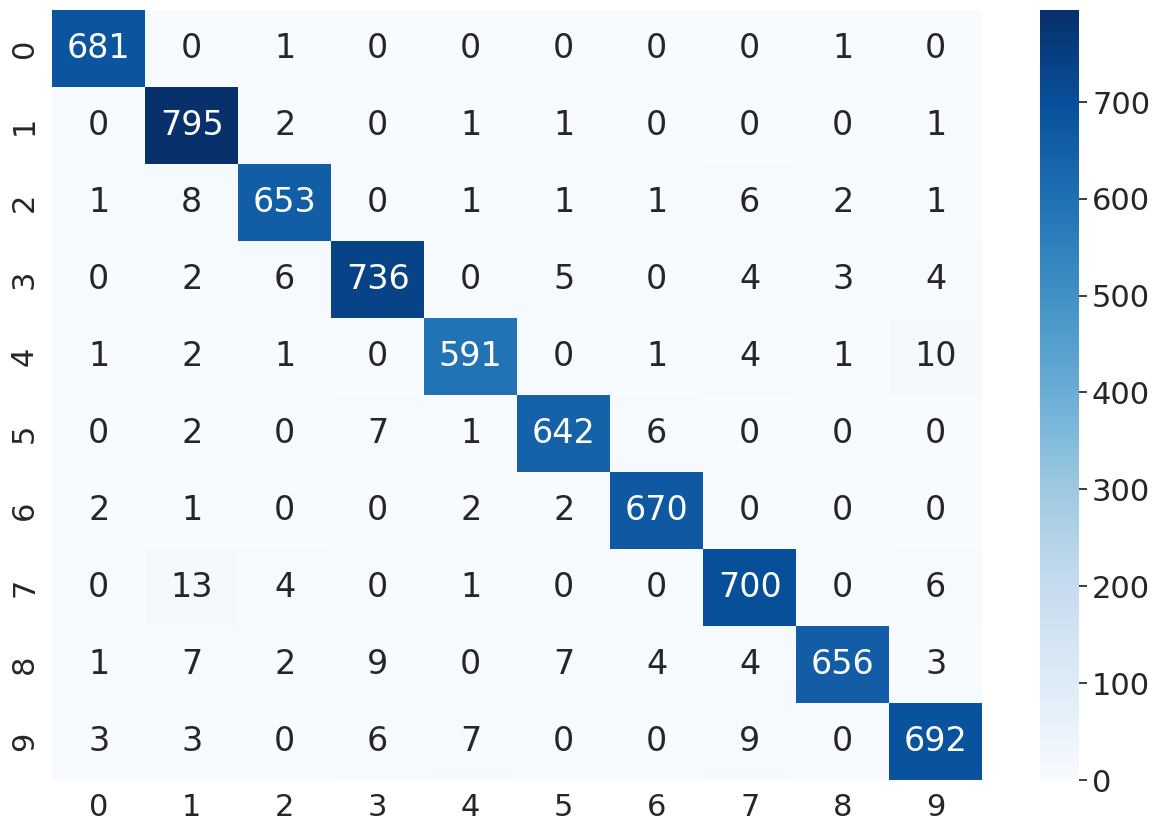

In [29]:
print(classification_report(test_labels, test_predicted_labels))
plotConfusionMatrix(test_labels, test_predicted_labels, np.unique(test_labels))

Como é possível ver, o KNN demonstrou ter um bom desempenho para a classificação de números escritos à mão provenientes do dataset MNIST, com acurácia de 97%.